## Projekt z przedmiotu PPSK


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn
from sklearn.calibration import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

Adding GPU to resources. Checking if GPU is available

In [2]:
from tensorflow.python.client import device_lib
#printing GPU devices
print(device_lib.list_local_devices())
#checking if tensorflow has cuda
print(tf.test.is_built_with_cuda())
#list of physical gpu compatible with CUDA architecture
print(tf.config.list_physical_devices('GPU'))

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4096752561489070517
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2962240308
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15610596109709150934
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Default GPU Device: /device:GPU:0


## Reading data

In [3]:
def read_data(dir):
  samples = []
  labels = []
  a = 0
  for data_dir in os.listdir(dir):
    if data_dir == 'benign':
      for file in os.listdir( dir + '\\' + data_dir):
         if os.path.isdir(dir + '\\' + data_dir + '\\' + file):
          continue
         print(file)
         if file.endswith('csv'):
          file_dir = dir + '\\' + data_dir + '\\' + file
          print(file_dir)
          untouched_logs = np.array(pd.read_csv(file_dir, delimiter=';').fillna(value = 0.0))
          if(len(samples) > 0):
            samples = np.vstack((samples, untouched_logs))
          else:
              samples = untouched_logs
          labels.extend(file[:-4] for i in range(len(untouched_logs)))
          a = a + 1
    elif data_dir == 'attacks':
      for class_dir in os.listdir(dir + '\\' +  data_dir):
        print(class_dir)
        for file in os.listdir(dir + '\\' + data_dir + '\\' + class_dir):
          if os.path.isdir(dir + '\\' + data_dir + '\\' + class_dir + '\\' + file):
            continue
          file_dir = dir + '\\' + data_dir + '\\' + class_dir + '\\' + file
          print(file_dir)
          if file.endswith('csv'):
            attacked_logs = np.array(pd.read_csv(file_dir, delimiter=';').fillna(value = 0.0))
            if(len(samples) > 0):
              samples = np.vstack((samples, attacked_logs))
            else:
              samples = attacked_logs
            labels.extend(class_dir for i in range(len(attacked_logs)))
  return (samples, labels)

In [4]:
path = 'C:\\Users\\tomek\\Desktop\\sem10\\PPSC\\TrainDataset'
(samples, labels) = read_data(path)
samples = np.array(samples)
labels = np.array(labels)
df = pd.DataFrame(samples)
print(samples)
print(df.shape)

false-data-injection
C:\Users\tomek\Desktop\sem10\PPSC\TrainDataset\attacks\false-data-injection\185.175.0.2.csv
loading-payloads
C:\Users\tomek\Desktop\sem10\PPSC\TrainDataset\attacks\loading-payloads\185.175.0.2.csv
modbus-frames-stacking
C:\Users\tomek\Desktop\sem10\PPSC\TrainDataset\attacks\modbus-frames-stacking\185.175.0.2.csv
modify-length-parameters
C:\Users\tomek\Desktop\sem10\PPSC\TrainDataset\attacks\modify-length-parameters\185.175.0.2.csv
query-flooding
C:\Users\tomek\Desktop\sem10\PPSC\TrainDataset\attacks\query-flooding\185.175.0.2.csv
no_attack.csv
C:\Users\tomek\Desktop\sem10\PPSC\TrainDataset\benign\no_attack.csv
[[0 '0x1d3d'
  'Mar 23. 2023 16:24:50.582520000 Środkowoeuropejski czas stand.' ...
  65152.0 0.0 13.0]
 [1 '0x1d3d'
  'Mar 23. 2023 16:24:50.582520000 Środkowoeuropejski czas stand.' ...
  65152.0 0.0 13.0]
 [2 '0x5e94'
  'Mar 23. 2023 16:24:50.582572000 Środkowoeuropejski czas stand.' ...
  65152.0 0.0 13.0]
 ...
 [2029 '0x6c38'
  'Jan 24. 2023 22:52:38.729

In [5]:
labels = np.array(labels)
df = pd.DataFrame(samples)
print(samples)
print(df.shape)

[[0 '0x1d3d'
  'Mar 23. 2023 16:24:50.582520000 Środkowoeuropejski czas stand.' ...
  65152.0 0.0 13.0]
 [1 '0x1d3d'
  'Mar 23. 2023 16:24:50.582520000 Środkowoeuropejski czas stand.' ...
  65152.0 0.0 13.0]
 [2 '0x5e94'
  'Mar 23. 2023 16:24:50.582572000 Środkowoeuropejski czas stand.' ...
  65152.0 0.0 13.0]
 ...
 [2029 '0x6c38'
  'Jan 24. 2023 22:52:38.729475000 Środkowoeuropejski czas stand.' ...
  64256.0 0.0 1.0]
 [2030 '0x0000'
  'Jan 24. 2023 12:22:53.310779000 Środkowoeuropejski czas stand.' ...
  65160.0 0.0 1.0]
 [2031 '0x6c39'
  'Jan 24. 2023 22:52:38.729602000 Środkowoeuropejski czas stand.' ...
  64256.0 'ede400000006010400080001' 13.0]]
(4064, 21)


In [6]:
lab = pd.DataFrame(labels)
print(labels)
print(lab.shape)

['false-data-injection' 'false-data-injection' 'false-data-injection' ...
 'no_attack' 'no_attack' 'no_attack']
(4064, 1)


Selecting features and data formating

In [7]:
def select_features(sample):
  sample = sample[:,[3,4,7,10,11,12,13,14,15,16,18,20]]
  return sample

In [8]:
def data_formating(packet):
  converted_packet = []
  print(packet)
  for feature in packet:
    converted_feature = 0
    try:
      converted_feature = float(feature)
    except ValueError:
      try:
        int_value = int(feature, 16) 
        converted_feature = float(int_value) 
      except ValueError:
        numeric_string = ''
        for signs in feature:
          print('conversion')
          numeric_string = numeric_string + str(ord(signs))
          converted_feature = float(numeric_string)
    converted_packet.append(converted_feature)
  print(converted_packet)
  return converted_packet

Changing data dimension

In [9]:
i = 0
train_data = []
data_batch = []
if samples.shape != (4064, 17):
  samples = select_features(samples)
for packet in samples:
  packet = data_formating(packet)
  if len(data_batch) > 0:
    data_batch = np.vstack((data_batch, packet))
  else:
    data_batch = packet
  if i == 3:
    i = -1
    train_data.append(data_batch)
    data_batch = []
  i = i + 1

[71.490208 6.0 502.0 56830.0 '0xaa21' 52.0 64.0 '0x738c' 0.0 71.44933
 65152.0 13.0]
[71.490208, 6.0, 502.0, 56830.0, 43553.0, 52.0, 64.0, 29580.0, 0.0, 71.44933, 65152.0, 13.0]
[71.490208 6.0 502.0 56830.0 '0xaa21' 52.0 64.0 '0x738c' 0.0 71.44933
 65152.0 13.0]
[71.490208, 6.0, 502.0, 56830.0, 43553.0, 52.0, 64.0, 29580.0, 0.0, 71.44933, 65152.0, 13.0]
[71.468636 6.0 502.0 56836.0 '0x68ca' 52.0 64.0 '0x738c' 0.0 71.425329
 65152.0 13.0]
[71.468636, 6.0, 502.0, 56836.0, 26826.0, 52.0, 64.0, 29580.0, 0.0, 71.425329, 65152.0, 13.0]
[71.468649 6.0 56836.0 502.0 '0xc76a' 40.0 64.0 '0x4633' 0.0 1.3e-05 0.0
 14.0]
[71.468649, 6.0, 56836.0, 502.0, 51050.0, 40.0, 64.0, 17971.0, 0.0, 1.3e-05, 0.0, 14.0]
[19073.693612 6.0 58678.0 1099.0 '0xaa20' 52.0 64.0 '0x738d' 0.0 1.7e-05
 502.0 7996058.0]
[19073.693612, 6.0, 58678.0, 1099.0, 43552.0, 52.0, 64.0, 29581.0, 0.0, 1.7e-05, 502.0, 7996058.0]
[19073.693612 6.0 58678.0 1099.0 '0xaa20' 52.0 64.0 '0x738d' 0.0 1.7e-05
 502.0 7996058.0]
[19073.693612, 

In [10]:
print(np.array(train_data))
print(len(train_data))
print(len(train_data[0]))
print(len(train_data[0][0]))
samples = train_data

[[[7.14902080e+01 6.00000000e+00 5.02000000e+02 ... 7.14493300e+01
   6.51520000e+04 1.30000000e+01]
  [7.14902080e+01 6.00000000e+00 5.02000000e+02 ... 7.14493300e+01
   6.51520000e+04 1.30000000e+01]
  [7.14686360e+01 6.00000000e+00 5.02000000e+02 ... 7.14253290e+01
   6.51520000e+04 1.30000000e+01]
  [7.14686490e+01 6.00000000e+00 5.68360000e+04 ... 1.30000000e-05
   0.00000000e+00 1.40000000e+01]]

 [[1.90736936e+04 6.00000000e+00 5.86780000e+04 ... 1.70000000e-05
   5.02000000e+02 7.99605800e+06]
  [1.90736936e+04 6.00000000e+00 5.86780000e+04 ... 1.70000000e-05
   5.02000000e+02 7.99605800e+06]
  [0.00000000e+00 6.00000000e+00 4.14940000e+04 ... 0.00000000e+00
   6.42400000e+04 1.00000000e+00]
  [4.30000000e-05 6.00000000e+00 5.02000000e+02 ... 4.30000000e-05
   6.51600000e+04 1.00000000e+00]]

 [[2.04542650e+01 6.00000000e+00 5.02000000e+02 ... 2.04099260e+01
   6.51520000e+04 1.20000000e+01]
  [2.04542650e+01 6.00000000e+00 5.02000000e+02 ... 2.04099260e+01
   6.51520000e+04 1.

In [11]:
labels.resize((1016, 4))
print(labels[: , 0])
print(len(labels[: , 0]))
i = 0
for row in labels[:, 0]:
  print(row + ' ' + str(train_data[i]))
  i = i + 1

['false-data-injection' 'false-data-injection' 'false-data-injection' ...
 'no_attack' 'no_attack' 'no_attack']
1016
false-data-injection [[7.1490208e+01 6.0000000e+00 5.0200000e+02 5.6830000e+04 4.3553000e+04
  5.2000000e+01 6.4000000e+01 2.9580000e+04 0.0000000e+00 7.1449330e+01
  6.5152000e+04 1.3000000e+01]
 [7.1490208e+01 6.0000000e+00 5.0200000e+02 5.6830000e+04 4.3553000e+04
  5.2000000e+01 6.4000000e+01 2.9580000e+04 0.0000000e+00 7.1449330e+01
  6.5152000e+04 1.3000000e+01]
 [7.1468636e+01 6.0000000e+00 5.0200000e+02 5.6836000e+04 2.6826000e+04
  5.2000000e+01 6.4000000e+01 2.9580000e+04 0.0000000e+00 7.1425329e+01
  6.5152000e+04 1.3000000e+01]
 [7.1468649e+01 6.0000000e+00 5.6836000e+04 5.0200000e+02 5.1050000e+04
  4.0000000e+01 6.4000000e+01 1.7971000e+04 0.0000000e+00 1.3000000e-05
  0.0000000e+00 1.4000000e+01]]
false-data-injection [[1.90736936e+04 6.00000000e+00 5.86780000e+04 1.09900000e+03
  4.35520000e+04 5.20000000e+01 6.40000000e+01 2.95810000e+04
  0.00000000e+00

## Encoding data

In [12]:
le = LabelEncoder()
labels = le.fit_transform(labels[:,1])
labels = tf.keras.utils.to_categorical(labels)
print(labels)
print("Labels shape",labels.shape)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]
Labels shape (1016, 6)


Labels Decode

In [13]:
single_labels = []
for label in np.ndarray.tolist(labels):
  if label not in single_labels:
    single_labels.append(label)
for single_label in single_labels:
  single_label = np.array([[single_label]])
  print('Label: ' + str(single_label[0][0]) + ' encoded as: ' + str(le.inverse_transform(single_label[0].reshape(1,6).argmax(axis = 1))) + '\n')

Label: [1. 0. 0. 0. 0. 0.] encoded as: ['false-data-injection']

Label: [0. 1. 0. 0. 0. 0.] encoded as: ['loading-payloads']

Label: [0. 0. 1. 0. 0. 0.] encoded as: ['modbus-frames-stacking']

Label: [0. 0. 0. 1. 0. 0.] encoded as: ['modify-length-parameters']

Label: [0. 0. 0. 0. 0. 1.] encoded as: ['query-flooding']

Label: [0. 0. 0. 0. 1. 0.] encoded as: ['no_attack']



Dividing dataset into train and test dataset

In [14]:
def dividingDataset(samples, labels, randomState, stratify, trainSize, testSize, shuffle):
  (trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples, labels, random_state=randomState
    , stratify=stratify, train_size=trainSize , test_size = testSize, shuffle=shuffle)
  print(trainSamples.shape)
  print(trainLabels.shape)
  print(testSamples.shape)
  print(testLabels.shape)
  return (trainSamples, testSamples, trainLabels, testLabels)

In [15]:
samples = np.array(samples)
labels = np.array(labels)
print(len(samples))
print(len(labels))
(trainSamples, testSamples, trainLabels, testLabels) = dividingDataset(samples, labels, 30, labels, 0.75, 0.25, True)

1016
1016
(762, 4, 12)
(762, 6)
(254, 4, 12)
(254, 6)


Crating CNN - LSTM Model

In [16]:
#Convolutional part
model=Sequential()
model.add(Conv1D(256, (3), padding="same", input_shape=(4, 12)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,(3),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.1))
model.add(Dense(128))
model.add(Dense(64))
#LSTM - Dense part
model.add(LSTM(64, input_shape=trainSamples.shape, return_sequences = True))
model.add(LSTM(128, input_shape=trainSamples.shape, return_sequences = True))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(6))
model.add(Activation("softmax"))

model.summary()
optimizer = tf.keras.optimizers.RMSprop(0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 256)            9472      
                                                                 
 batch_normalization (BatchN  (None, 4, 256)           1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 4, 256)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 256)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            98432     
                                                                 
 batch_normalization_1 (Batc  (None, 2, 128)           5

In [26]:
BATCH = 32
EPOCHS = 50
#for i in range(10):
H = model.fit(trainSamples, trainLabels, batch_size = BATCH, epochs=EPOCHS, steps_per_epoch=16, validation_data=(testSamples,testLabels))

Epoch 1/50
16/16 [==============================] - 1s 58ms/step - loss: 0.6021 - accuracy: 0.7617 - val_loss: 1.2416 - val_accuracy: 0.5827
Epoch 2/50
16/16 [==============================] - 1s 53ms/step - loss: 0.6389 - accuracy: 0.7510 - val_loss: 1.1945 - val_accuracy: 0.5787
Epoch 3/50
16/16 [==============================] - 1s 52ms/step - loss: 0.5889 - accuracy: 0.7708 - val_loss: 1.2291 - val_accuracy: 0.6142
Epoch 4/50
16/16 [==============================] - 1s 52ms/step - loss: 0.5812 - accuracy: 0.7559 - val_loss: 1.2436 - val_accuracy: 0.5827
Epoch 5/50
16/16 [==============================] - 1s 52ms/step - loss: 0.5489 - accuracy: 0.7984 - val_loss: 1.2419 - val_accuracy: 0.5630
Epoch 6/50
16/16 [==============================] - 1s 51ms/step - loss: 0.5798 - accuracy: 0.7530 - val_loss: 1.2000 - val_accuracy: 0.6024
Epoch 7/50
16/16 [==============================] - 1s 52ms/step - loss: 0.5977 - accuracy: 0.7539 - val_loss: 1.2224 - val_accuracy: 0.5827
Epoch 8/50
16

In [27]:
def showTrainingHistory(epoch,outputH):
  N = np.arange(0, epoch)
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(N, outputH.history["loss"], label="train_loss")
  plt.plot(N, outputH.history["accuracy"], label="train_accuracy")
  plt.plot(N, outputH.history["val_loss"], label="val_loss")
  plt.plot(N, outputH.history["val_accuracy"], label="val_accuracy")

  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()
  return

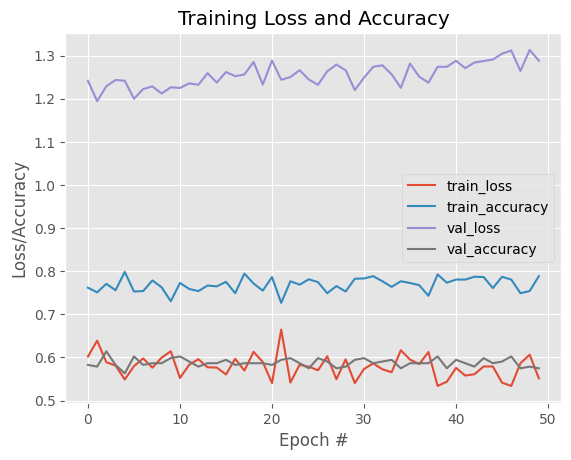

In [28]:
showTrainingHistory(EPOCHS,H)

In [29]:
def showModelTrainingResults(testResults, testLabels):
  print(confusion_matrix(testLabels, testResults))
  print(classification_report(testLabels, testResults))
  print("Cohen's Kappa: {}".format(cohen_kappa_score(testLabels, testResults)))
  print("Accuracy: ",accuracy_score(testLabels, testResults))
  return

In [30]:
testResults = model.predict(testSamples)

print(testLabels)

testResultsMax = testResults.argmax(axis=1)
testLabelsMax = testLabels.argmax(axis=1)

showModelTrainingResults(testResultsMax, testLabelsMax)

8/8 [==============================] - 0s 28ms/step
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]
[[  8   1   4   5   1   8]
 [  6   2   2   2   0   4]
 [  4   4   0   5   1   6]
 [  6   7   5   6   0  10]
 [  0   0   0   2 121   4]
 [  4   2   2  13   0   9]]
              precision    recall  f1-score   support

           0       0.29      0.30      0.29        27
           1       0.12      0.12      0.12        16
           2       0.00      0.00      0.00        20
           3       0.18      0.18      0.18        34
           4       0.98      0.95      0.97       127
           5       0.22      0.30      0.25        30

    accuracy                           0.57       254
   macro avg       0.30      0.31      0.30       254
weighted avg       0.58      0.57      0.58       254

Cohen's Kappa: 0.39404917055068367
Accuracy:  0.5748031496062992


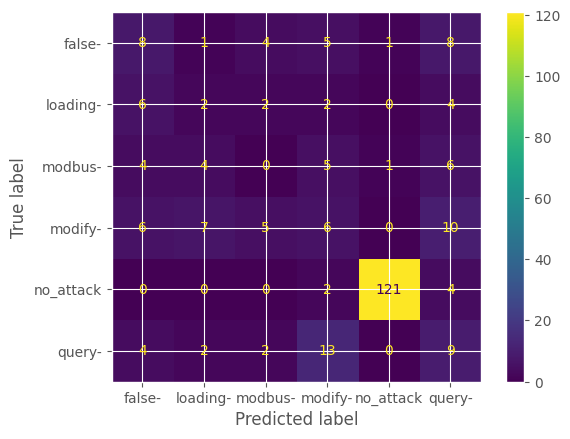

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay


cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(testLabelsMax, testResultsMax), display_labels = ['false-', 'loading-', 'modbus-', 'modify-', 'no_attack', 'query-'])

cm_display.plot()
plt.show()

In [34]:
model.save('modbus_cnn_lstm1.h5')

Showing training results

In [33]:
import random

for i in range(9):
    rand = random.randint(0, len(testSamples)-1)
    print('Test class: ' + str(le.inverse_transform(testLabels[rand].reshape(1,6).argmax(axis = 1))) + ' classified as class: ' + str(le.inverse_transform(testResults[rand].reshape(1,6).argmax(axis = 1))) + ' with probability: ' + str("{:.2f}".format(round((testResults[rand].reshape(1,6).max(axis=1)[0]*100), 2))) + '%')
    print('Probabilites for all classes:\n')
    i = 0
    for i in range(0, len(testResults[rand]-1)):
        print('Probability for class: ' + str(le.inverse_transform([i])[0]) + ' = ' + str("{:.2f}".format(round((testResults[rand][i]*100), 2))) + '%')
        i = i + 1
    print('\n')

Test class: ['false-data-injection'] classified as class: ['query-flooding'] with probability: 50.34%
Probabilites for all classes:

Probability for class: false-data-injection = 25.92%
Probability for class: loading-payloads = 9.77%
Probability for class: modbus-frames-stacking = 9.97%
Probability for class: modify-length-parameters = 3.99%
Probability for class: no_attack = 0.01%
Probability for class: query-flooding = 50.34%


Test class: ['query-flooding'] classified as class: ['false-data-injection'] with probability: 55.42%
Probabilites for all classes:

Probability for class: false-data-injection = 55.42%
Probability for class: loading-payloads = 0.85%
Probability for class: modbus-frames-stacking = 18.13%
Probability for class: modify-length-parameters = 12.46%
Probability for class: no_attack = 0.35%
Probability for class: query-flooding = 12.79%


Test class: ['modbus-frames-stacking'] classified as class: ['loading-payloads'] with probability: 62.91%
Probabilites for all cla